Import necessary Libraries

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import warnings
import matplotlib.ticker as ticker
import joblib
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import KFold
from sklearn.linear_model import Ridge
from sodapy import Socrata 
import glob 
import os 
warnings.filterwarnings("ignore")

C:\Users\mende\anaconda3\lib\site-packages\scipy\__init__.py:138: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5)
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion} is required for this version of "


In [2]:
# In[2]:



APP_TOKEN = "oMcgh3hh3fn1djGiFPyKWrPoC"


# In[3]:


client = Socrata("data.cityofnewyork.us", app_token = APP_TOKEN)


# In[4]:


DATASET_ID = "w2pb-icbu"
BATCH_SIZE = 50000
offset = 0 
batch_num = 0 


# In[5]:


while True: 
    print (f"Fetching rows {offset} to {offset + BATCH_SIZE}...")
    
    results= client.get(DATASET_ID, limit = BATCH_SIZE, offset=offset)
    
    if not results : 
        print("No more records to fetch.")
        break
    df=pd.DataFrame.from_records(results)
    
    output_filename = (f"nyc_data_batch_{batch_num:03d}.csv")
    df.to_csv(output_filename, index = False)
    print(f"saved {len(df)} rows to {output_filename}")
    
    offset += BATCH_SIZE
    batch_num +=1


# In[6]:


csv_files = sorted(glob.glob("nyc_data_batch_*.csv"))
print(f"found{len(csv_files)} files to merge.")


# In[7]:


df_iter = (pd.read_csv(f) for f in csv_files) 
print("Merging all batches into one DataFrame...")
merged_df = pd.concat(df_iter, ignore_index = False)

output_file = "nyc_data_all.csv"
merged_df.to_csv(output_file, index = False)
print(f"Saved merged data to {output_file}")


# In[8]:


csv_files = glob.glob("nyc_data_batch_*.csv")

for f in csv_files: 
    os.remove(f)
    print (f"Deleted {f}")
print("All batches have been deleted")


# In[ ]:



Fetching rows 0 to 50000...
saved 50000 rows to nyc_data_batch_000.csv
Fetching rows 50000 to 100000...
saved 50000 rows to nyc_data_batch_001.csv
Fetching rows 100000 to 150000...
saved 50000 rows to nyc_data_batch_002.csv
Fetching rows 150000 to 200000...
saved 50000 rows to nyc_data_batch_003.csv
Fetching rows 200000 to 250000...
saved 50000 rows to nyc_data_batch_004.csv
Fetching rows 250000 to 300000...
saved 50000 rows to nyc_data_batch_005.csv
Fetching rows 300000 to 350000...
saved 50000 rows to nyc_data_batch_006.csv
Fetching rows 350000 to 400000...
saved 50000 rows to nyc_data_batch_007.csv
Fetching rows 400000 to 450000...
saved 50000 rows to nyc_data_batch_008.csv
Fetching rows 450000 to 500000...
saved 50000 rows to nyc_data_batch_009.csv
Fetching rows 500000 to 550000...
saved 50000 rows to nyc_data_batch_010.csv
Fetching rows 550000 to 600000...
saved 50000 rows to nyc_data_batch_011.csv
Fetching rows 600000 to 650000...
saved 50000 rows to nyc_data_batch_012.csv
Fetchi

Import and preliminary exploration of data

In [3]:
### Reads the csv file
### Creates first data frame, df
df = pd.read_csv("nyc_data_all.csv")

Describes the data


In [4]:
df.describe()

,borough,block,lot,zip_code,residential_units,commercial_units,total_units,year_built,tax_class_at_time_of_sale,sale_price,latitude,longitude,community_board,council_district,bin,bbl,census_tract_2020
count,760914.000000,760914.000000,760914.000000,760866.000000,647911.000000,584372.000000,659062.000000,727043.000000,760914.000000,7.609140e+05,739355.000000,739355.000000,739356.000000,739356.000000,7.365060e+05,7.365060e+05,739609.000000
mean,2.991342,4255.010980,378.425271,10811.656691,2.608099,0.278114,2.830257,1887.076052,1.646218,1.288947e+06,40.708331,-73.931252,306.207583,26.587107,3.133647e+06,3.023239e+09,12335.612475
std,1.293127,3593.694475,660.320457,864.475931,21.807325,7.082649,22.726700,349.876123,0.808926,1.085983e+07,0.079797,0.103014,128.903477,15.760800,1.346170e+06,1.312340e+09,28745.815606
min,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000e+00,40.498887,-74.254937,101.000000,1.000000,1.000000e+06,0.000000e+00,1.000000
25%,2.000000,1299.000000,22.000000,10305.000000,1.000000,0.000000,1.000000,1922.000000,1.000000,0.000000e+00,40.648978,-73.984565,208.000000,13.000000,2.047729e+06,2.037490e+09,171.000000
50%,3.000000,3322.000000,50.000000,11209.000000,1.000000,0.000000,1.000000,1945.000000,2.000000,4.684840e+05,40.714325,-73.945372,313.000000,27.000000,3.226062e+06,3.061830e+09,506.000000
75%,4.000000,6306.000000,1001.000000,11357.000000,2.000000,0.000000,2.000000,1970.000000,2.000000,9.250000e+05,40.761660,-73.856633,408.000000,40.000000,4.205882e+06,4.062640e+09,9701.000000
max,5.000000,16350.000000,9139.000000,11697.000000,8764.000000,2261.000000,8812.000000,2024.000000,4.000000,2.397502e+09,40.912869,-73.700376,595.000000,51.000000,5.516445e+06,5.080500e+09,157903.000000


In [5]:
###Gives information about the data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 760914 entries, 0 to 760913
Data columns (total 28 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   borough                     760914 non-null  int64  
 1   neighborhood                760914 non-null  object 
 2   building_class_category     760914 non-null  object 
 3   tax_class_as_of_final_roll  756731 non-null  object 
 4   block                       760914 non-null  int64  
 5   lot                         760914 non-null  int64  
 6   building_class_as_of_final  756731 non-null  object 
 7   address                     760914 non-null  object 
 8   apartment_number            187994 non-null  object 
 9   zip_code                    760866 non-null  float64
 10  residential_units           647911 non-null  float64
 11  commercial_units            584372 non-null  float64
 12  total_units                 659062 non-null  float64
 13  land_square_fe

Zero value calculation

In [6]:
###Checks all variables for zeros or null values
print('Missing values per column:')
missing_values = df.isnull().sum()
print(missing_values)

Missing values per column:
borough                            0
neighborhood                       0
building_class_category            0
tax_class_as_of_final_roll      4183
block                              0
lot                                0
building_class_as_of_final      4183
address                            0
apartment_number              572920
zip_code                          48
residential_units             113003
commercial_units              176542
total_units                   101852
land_square_feet              187695
gross_square_feet             187692
year_built                     33871
tax_class_at_time_of_sale          0
building_class_at_time_of          0
sale_price                         0
sale_date                          0
latitude                       21559
longitude                      21559
community_board                21558
council_district               21558
bin                            24408
bbl                            24408
census_trac

Creates a a list of the critical columns used for the analysis,drops na values from the critical columns.

In [7]:
critical_columns = ['total_units', 'residential_units', 'gross_square_feet',
                    'land_square_feet', 'year_built', 'sale_price', 'borough']
df_na = df.dropna(subset=critical_columns)


In [8]:
### Creates an updated dataframe with just targets and features
df_1=df_na[['total_units', 'residential_units',
          'gross_square_feet','land_square_feet', 'year_built', 'sale_price', 'borough']].copy()

### Remaps Borough from number to name
borough_map = {
1: "Manhattan",
2: "The Bronx",
3: "Brooklyn",
4: "Queens",
5:"Staten Island"
}

### Maps boroughs to names
df_1["borough_name"]= df_1["borough"].map(borough_map)
### Converts gross square feet into numerical data
df_1['gross_square_feet'] = pd.to_numeric(df_1['gross_square_feet'], errors='coerce')
### Replace 0s with NaNs for critical fields
critical_cols = ['gross_square_feet', 'land_square_feet', 'residential_units', 'year_built']
df_1[critical_cols] = df_1[critical_cols].replace(0, np.nan)
### Calculate derived features
df_1['units_per_sqft_pct'] = (df_1['total_units'] / df_1['gross_square_feet']) * 100
df_1['units_per_sqft_pct'] = df_1['units_per_sqft_pct'].round(2)
### Uses a rolling mean based on borough and year built to populate missing residenital unit rows.
df_1 = df_1.sort_values(by=['borough', 'year_built'])
rolling_avg = (
    df_1.groupby('borough')['residential_units']
    .transform(lambda x: x.rolling(window=5, min_periods=1, center=True).mean())
)
df_1['residential_units'] = df_1['residential_units'].fillna(rolling_avg).round()
df_1['residential_units'] = (
    df_1.groupby('borough')['residential_units']
    .transform(lambda x: x.ffill().bfill())
)

##Drop rows with any remaining NaNs in critical columns, creating a new dataframe, df_1
df_1 = df_1.dropna(subset=critical_cols + ['units_per_sqft_pct'])

### Runs a final check oto view the shape and count of df_1 frame.
print("Remaining rows:", df_1.shape[0])
df_1.info()



Remaining rows: 65908
<class 'pandas.core.frame.DataFrame'>
Int64Index: 65908 entries, 355435 to 656864
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   total_units         65908 non-null  float64
 1   residential_units   65908 non-null  float64
 2   gross_square_feet   65908 non-null  float64
 3   land_square_feet    65908 non-null  object 
 4   year_built          65908 non-null  float64
 5   sale_price          65908 non-null  int64  
 6   borough             65908 non-null  int64  
 7   borough_name        65908 non-null  object 
 8   units_per_sqft_pct  65908 non-null  float64
dtypes: float64(5), int64(2), object(2)
memory usage: 5.0+ MB


Recheck for zero values on new data frame

In [9]:
### Checks each column for zeros values
for col in df_1.columns:
    if col != 'borough_name' or 'borough':
        zero_count = (df_1[col] == 0).sum()
        print(f"{col}: {zero_count} zero values")

total_units: 147 zero values
residential_units: 0 zero values
gross_square_feet: 0 zero values
land_square_feet: 0 zero values
year_built: 0 zero values
sale_price: 24426 zero values
borough: 0 zero values
borough_name: 0 zero values
units_per_sqft_pct: 364 zero values


In [10]:
print("NaN values:", df_1['units_per_sqft_pct'].isna().sum())
print("Zero values:", (df_1['units_per_sqft_pct'] == 0).sum())
print("Inf values:", np.isinf(df_1['units_per_sqft_pct']).sum())

NaN values: 0
Zero values: 364
Inf values: 0


Analysis of the target variable and removing any extreme outliers

In [11]:
### Calculates the interquartile range for the sale price.
Q1 = df_1['sale_price'].quantile(0.25)
Q3 = df_1['sale_price'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

### Filter out extreme outliers
df_2 = df_1[(df_1['sale_price'] >= lower_bound) & (df_1['sale_price'] <= upper_bound)]
print("Min:", df_2['sale_price'].min())
print("Max:", df_2['sale_price'].max())
print("Shape after filtering:", df_2.shape)

Min: 0
Max: 1755000
Shape after filtering: (63108, 9)


Applying a log transformation to price to reduce skew

In [12]:
### Dealing with price over time a log scale transformation is applied to sale_price.
df_2['log_sale_price'] = np.log1p(df_2['sale_price'])

Side by side visual comparsion of sale price, before and after log scale

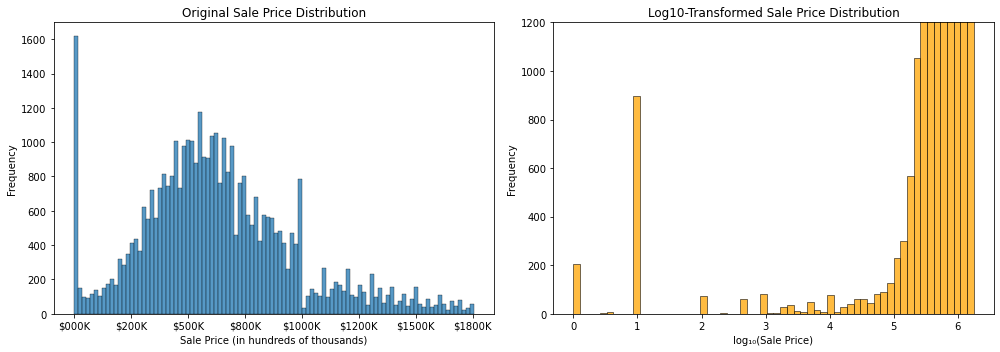

In [13]:
### Create 100k version of sale price
df_2['sale_price_100k'] = df_2['sale_price'] / 100_000
df_2['log_sale_price'] = np.log1p(df_2['sale_price'])

### Use log base 10
df_2['log10_sale_price'] = np.where(df_2['sale_price'] > 0, np.log10(df_2['sale_price']), np.nan)
df_2 = df_2.dropna(subset=['log10_sale_price'])

### Set up side-by-side plots
plt.figure(figsize=(14, 5))

### Plot 1: Original Sale Price (in 100k)
plt.subplot(1, 2, 1)
sns.histplot(df_2['sale_price_100k'], bins=100, edgecolor='black')
plt.title('Original Sale Price Distribution')
plt.xlabel('Sale Price (in hundreds of thousands)')
plt.ylabel('Frequency')
plt.gca().xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f'${x:.0f}00K'))
### Plot 2: Log base 10 transformation of sale price distribution.
plt.subplot(1, 2, 2)
sns.histplot(df_2['log10_sale_price'], bins=60, edgecolor='black', color='orange')
plt.title('Log10-Transformed Sale Price Distribution')
plt.xlabel('log\u2081\u2080(Sale Price)') ###Adds a subscrit 10 to log on the x axis.
plt.ylabel('Frequency')
plt.ylim(0, 1200)

plt.tight_layout()
plt.show()


In [14]:
### Gives information about df_2.
df_2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 38682 entries, 225632 to 656864
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   total_units         38682 non-null  float64
 1   residential_units   38682 non-null  float64
 2   gross_square_feet   38682 non-null  float64
 3   land_square_feet    38682 non-null  object 
 4   year_built          38682 non-null  float64
 5   sale_price          38682 non-null  int64  
 6   borough             38682 non-null  int64  
 7   borough_name        38682 non-null  object 
 8   units_per_sqft_pct  38682 non-null  float64
 9   log_sale_price      38682 non-null  float64
 10  sale_price_100k     38682 non-null  float64
 11  log10_sale_price    38682 non-null  float64
dtypes: float64(8), int64(2), object(2)
memory usage: 3.8+ MB


convert land square feet from object to float

In [15]:
df_2['land_square_feet'] = df_2['land_square_feet'].astype(str).str.replace(',', '').str.strip()
df_2['land_square_feet'] = pd.to_numeric(df_2['land_square_feet'], errors='coerce')

Creates a net square foot variable. Gross square feet - land square feet is the net square footage of just the building. If land square feet equals gross square feet then the plot sold is just the building's foot print with no additional land

In [16]:
df_2['net_square_feet'] = np.where(
    df_2['land_square_feet'] == df_2['gross_square_feet'],
    df_2['gross_square_feet'],
    abs(df_2['gross_square_feet'] - df_2['land_square_feet'])
)


Checking to ensure that net_square_feet values are above positive and dropping any values that are nan.

In [17]:
(df_2['net_square_feet'].dropna() >= 0).all()


True

In [18]:
df_2[df_2['net_square_feet'] <= 0]

,total_units,residential_units,gross_square_feet,land_square_feet,year_built,sale_price,borough,borough_name,units_per_sqft_pct,log_sale_price,sale_price_100k,log10_sale_price,net_square_feet


In [19]:
df_2 = df_2.dropna()
df_2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 38682 entries, 225632 to 656864
Data columns (total 13 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   total_units         38682 non-null  float64
 1   residential_units   38682 non-null  float64
 2   gross_square_feet   38682 non-null  float64
 3   land_square_feet    38682 non-null  float64
 4   year_built          38682 non-null  float64
 5   sale_price          38682 non-null  int64  
 6   borough             38682 non-null  int64  
 7   borough_name        38682 non-null  object 
 8   units_per_sqft_pct  38682 non-null  float64
 9   log_sale_price      38682 non-null  float64
 10  sale_price_100k     38682 non-null  float64
 11  log10_sale_price    38682 non-null  float64
 12  net_square_feet     38682 non-null  float64
dtypes: float64(10), int64(2), object(1)
memory usage: 4.1+ MB


Correlation of variables


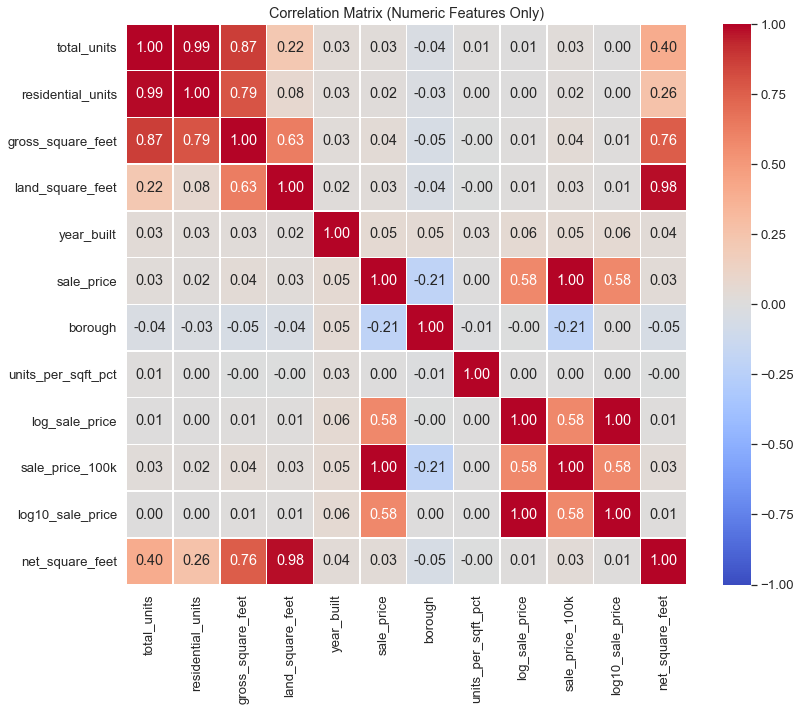

In [20]:
### Style settings for readability
sns.set(style='white', font_scale=1.2)

### Use only numeric columns that exist in df_2
df_numeric = df_2.select_dtypes(include=['number'])

### Compute correlation matrix
corr_matrix = df_numeric.corr()

### Plot heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(
    corr_matrix, annot=True, fmt=".2f", cmap='coolwarm',
    center=0, square=True, linewidths=0.5, vmin=-1, vmax=1
)
plt.title("Correlation Matrix (Numeric Features Only)")
plt.tight_layout()
plt.show()

One hot encoding on borough_name

In [21]:
df_3 =pd.get_dummies(df_2, columns=['borough_name'], prefix='borough', drop_first=False, dtype=int)
df_3.head()
df_3.to_csv("Regression_Dataframe.csv", index = True)

Split variables into targe and features

Target Variable

In [22]:
y_price = df_3["sale_price"]
y_price_log = df_3["log_sale_price"]
y_price_log10 = df_3["log10_sale_price"]

Features

In [23]:
X = df_3.drop(["sale_price", "log_sale_price", "log10_sale_price", "borough", "sale_price_100k"], axis=1)

In [24]:
print(f'Features shape: {X.shape}')
print(f'Target shape: {y_price.shape}')
print(f'Target shape: {y_price_log.shape}')
print(f'Target shape: {y_price_log10.shape}')


Features shape: (38682, 12)
Target shape: (38682,)
Target shape: (38682,)
Target shape: (38682,)


Double Check Feature Names

In [25]:
print(f'Feature names: {list(X.columns)}')

Feature names: ['total_units', 'residential_units', 'gross_square_feet', 'land_square_feet', 'year_built', 'units_per_sqft_pct', 'net_square_feet', 'borough_Brooklyn', 'borough_Manhattan', 'borough_Queens', 'borough_Staten Island', 'borough_The Bronx']


Plot of target and features


Splits Data into Testing and Training

In [26]:
### SPLIT once and keep everything aligned
X_train, X_test, y1_train, y1_test, y2_train, y2_test, y3_train, y3_test = train_test_split(
    X, y_price, y_price_log, y_price_log10, test_size=0.2, random_state=42
)

### SCALE only the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

### TRAIN each model
model_raw = LinearRegression().fit(X_train_scaled, y1_train)
model_log = LinearRegression().fit(X_train_scaled, y2_train)
model_log10 = LinearRegression().fit(X_train_scaled, y3_train)



### PREDICT and SCORE
print("R² for raw price:    ", round(r2_score(y1_test, model_raw.predict(X_test_scaled)), 4))
print("R² for log(price):   ", round(r2_score(y2_test, model_log.predict(X_test_scaled)), 4))
print("R² for log10(price): ", round(r2_score(y3_test, model_log10.predict(X_test_scaled)), 4))

R² for raw price:     0.0926
R² for log(price):    0.0049
R² for log10(price):  0.0048


In [27]:
### True if NaNs exist
print(np.any(np.isnan(y3_train)))
# True if infinities exist
print(np.any(np.isinf(y3_train)))

False
False


Regression for Total Units

In [28]:
df_3['floor_area_ratio'] = df_3['gross_square_feet'] / df_3['land_square_feet']
df_3['floor_area_ratio'].replace([np.inf, -np.inf], np.nan, inplace=True)
df_3.dropna(subset=['floor_area_ratio'], inplace=True)
df_3.to_csv("Streamlit_dataset.csv", index=False)

In [29]:
y_total_units = df_3["total_units"]
X_units = df_3.drop(["log10_sale_price", "borough", "sale_price_100k",'total_units', "log_sale_price","total_units","residential_units", 'borough'],axis =1)

X_train, X_test, y_train, y_test = train_test_split(
    X_units, y_total_units, test_size=0.2, random_state=42
)

### Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

### Fit linear regression model
multiple_model = LinearRegression()
multiple_model.fit(X_train_scaled, y_train)

### Predict on both train and test sets
y_pred_train = multiple_model.predict(X_train_scaled)
y_pred_test = multiple_model.predict(X_test_scaled)

joblib.dump(multiple_model, 'multiple_linear_model.pkl')
joblib.dump(scaler, 'scaler.pkl')


['scaler.pkl']

In [30]:
print(scaler.n_features_in_)

12


In [31]:
X_units.columns

Index(['gross_square_feet', 'land_square_feet', 'year_built', 'sale_price',
       'units_per_sqft_pct', 'net_square_feet', 'borough_Brooklyn',
       'borough_Manhattan', 'borough_Queens', 'borough_Staten Island',
       'borough_The Bronx', 'floor_area_ratio'],
      dtype='object')

In [32]:
### calculate performance metrics for both training and testing sets
def calculate_metrics(y_true, y_pred, dataset):
  mse = mean_squared_error(y_true, y_pred)
  rmse = np.sqrt(mse)
  mae = mean_absolute_error(y_true, y_pred)
  r2 = r2_score(y_true, y_pred)

  print(f'Performance Metrics: {dataset}')
  print(f"Mean Squared Error (MSE): {mse:.4f}")
  print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
  print(f"Mean Absolute Error (MAE): {mae:.4f}")
  print(f"R-squared (R²) Score: {r2:.4f}")

In [33]:
calculate_metrics(y_train, y_pred_train, "Training")

Performance Metrics: Training
Mean Squared Error (MSE): 232.5172
Root Mean Squared Error (RMSE): 15.2485
Mean Absolute Error (MAE): 1.6093
R-squared (R²) Score: 0.9260


In [34]:
calculate_metrics(y_test, y_pred_test, "Testing")

Performance Metrics: Testing
Mean Squared Error (MSE): 14.7893
Root Mean Squared Error (RMSE): 3.8457
Mean Absolute Error (MAE): 1.4517
R-squared (R²) Score: 0.9610


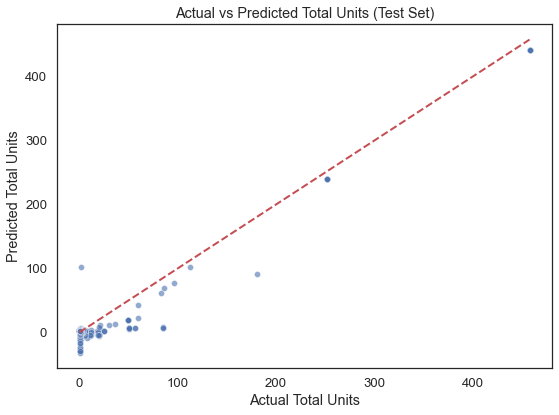

In [35]:
### Plot of line of best fit
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test, y=y_pred_test, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', linewidth=2)
plt.xlabel("Actual Total Units")
plt.ylabel("Predicted Total Units")
plt.title("Actual vs Predicted Total Units (Test Set)")
plt.tight_layout()
plt.show()

<Figure size 504x360 with 0 Axes>

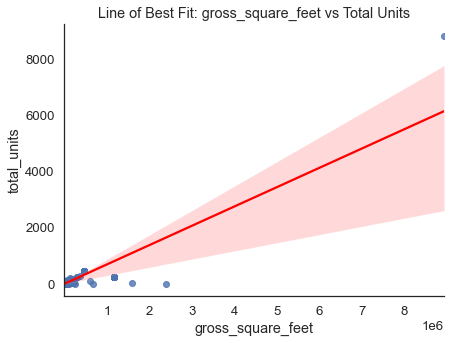

<Figure size 504x360 with 0 Axes>

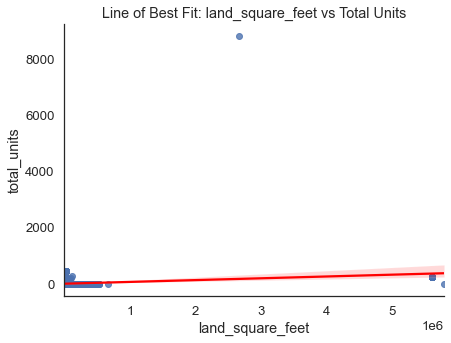

<Figure size 504x360 with 0 Axes>

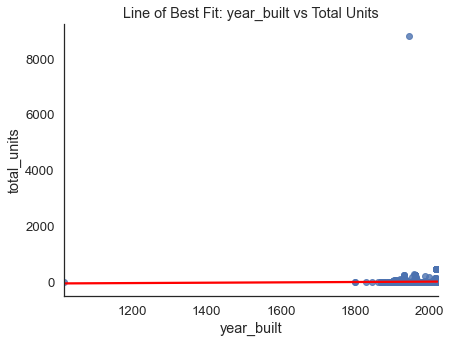

<Figure size 504x360 with 0 Axes>

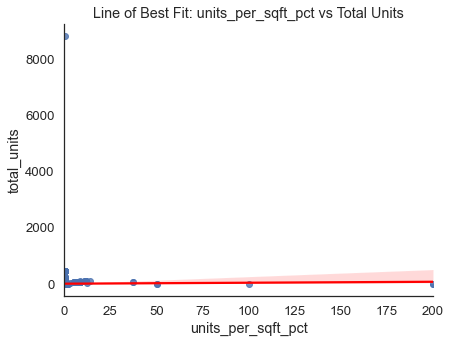

<Figure size 504x360 with 0 Axes>

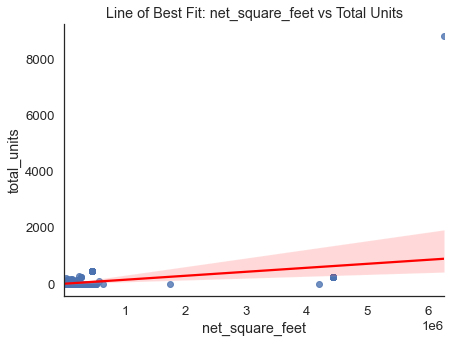

In [36]:
### Uses a for loop to plot multiple line of best fit for each variable versus the targe - Total units.
features = [
    'gross_square_feet', 'land_square_feet', 'year_built', 'units_per_sqft_pct',
    'net_square_feet'
]

for feature in features:
    plt.figure(figsize=(7, 5))
    sns.lmplot(x=feature, y='total_units', data=df_3, aspect=1.3, line_kws={'color': 'red'})
    plt.title(f'Line of Best Fit: {feature} vs Total Units')
    plt.tight_layout()
    plt.show()

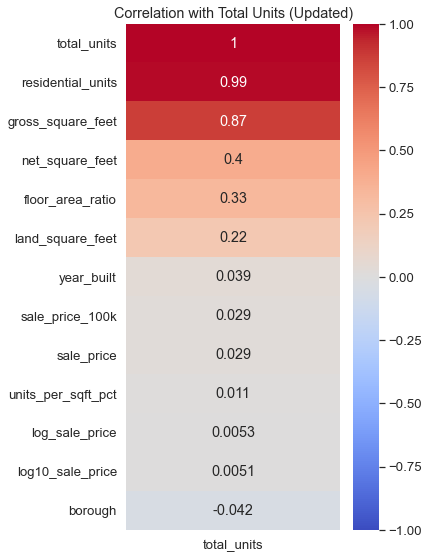

In [37]:
###  Creates a correlation matrixs with just Total Units versus the features.
df_3['floor_area_ratio'] = pd.to_numeric(df_3['floor_area_ratio'], errors='coerce')

### Select numeric columns again
df_numeric = df_3.select_dtypes(include=["float64", "int64"])

### Recalculate correlation
corr_matrix = df_numeric.corr()

### Visualize correlation with total_units
corr_target = corr_matrix[["total_units"]].sort_values(by="total_units", ascending=False)

plt.figure(figsize=(6, 8))
sns.heatmap(corr_target, annot=True, cmap="coolwarm", vmin=-1, vmax=1)
plt.title("Correlation with Total Units (Updated)")
plt.tight_layout()
plt.show()

PCA

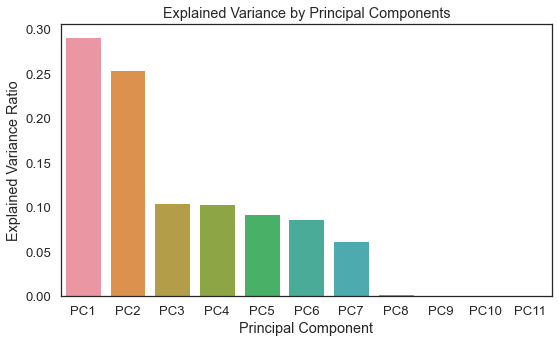

In [38]:
### Select only numeric features
features = df_2.select_dtypes(include=['float64', 'int64']).drop(columns=['total_units'])

### Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(features)

### Fit PCA
pca = PCA()
X_pca = pca.fit_transform(X_scaled)

### Create a DataFrame of explained variance
explained_variance = pd.DataFrame({
    'Principal Component': [f'PC{i+1}' for i in range(len(pca.explained_variance_ratio_))],
    'Explained Variance Ratio': pca.explained_variance_ratio_
})

### Plot explained variance
plt.figure(figsize=(8, 5))
sns.barplot(x='Principal Component', y='Explained Variance Ratio', data=explained_variance)
plt.title('Explained Variance by Principal Components')
plt.tight_layout()
plt.show()

In [39]:
loadings = pd.DataFrame(
    pca.components_.T,
    columns=[f'PC{i+1}' for i in range(len(pca.components_))],
    index=features.columns
)

### Show top contributing features to the first component
top_features = loadings['PC1'].abs().sort_values(ascending=False)
print("Top contributing features to PC1:")
print(top_features)

Top contributing features to PC1:
sale_price_100k       0.489777
sale_price            0.489777
log_sale_price        0.477482
log10_sale_price      0.476159
gross_square_feet     0.129946
net_square_feet       0.127526
land_square_feet      0.114558
borough               0.100359
residential_units     0.078806
year_built            0.054287
units_per_sqft_pct    0.004296
Name: PC1, dtype: float64
